# Exercise 3 Digits - Multi Layer Perceptron 

## Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from perceptron import MultiLayerPerceptron
from optimizer import SGD_Optimizer, MomentumOptimizer, AdamOptimiser
from sklearn.model_selection import train_test_split
import pandas as pd

## Configurations

In [13]:
# Optimizer settings
learning_rate = 0.1
batch_size    = 4             # full-batch for XOR
epochs        = 1000

# Verbosity / logging
verbose       = True
shuffle       = False
loss_kind     = 'cross_entropy'
runs_per_config = 5

## Load Data

In [14]:
with open("../data/TP3-ej3-digitos.txt") as f:
    # strip out any empty lines
    lines = [line.strip() for line in f if line.strip()]

blocks = [lines[i:i+7] for i in range(0, len(lines), 7)]
X = np.array([[int(b) for row in block for b in row.split()]
              for block in blocks])   

## Testing Odd or Even

### Build Labels

In [15]:
digits = np.arange(len(blocks))           # [0,1,2,…,9]
y01 = (digits % 2).reshape(-1, 1)

### Initial Parity Test

#### Instansiate and Fit

In [16]:
mlp = MultiLayerPerceptron(
    layer_sizes=[35, 16, 1], 
    optimizer=SGD_Optimizer(0.05), 
    activations=['tanh', 'sigmoid'], 
    learning_rate=0.05,
    batch_size=10,                  
    shuffle=False,
    loss_kind='cross_entropy',
    verbose=True
)

mlp.fit(X, y01, epochs=500)

Epoch 500 — loss: 0.0192, acc: 1.000


#### Predict And Compute Accuracy

In [17]:
probs = mlp.predict_proba_batch(X).ravel()          # shape (10,), floats in [0,1]
preds = (probs >= 0.5).astype(int)                  # 0=even,1=odd
acc   = (preds.reshape(-1,1) == y01).mean()   

print(f"Parity detection accuracy: {acc*100:.1f}%")

df = pd.DataFrame({
    'Digit':     digits,
    'Probability(odd)': probs,
    'Prediction': ['odd'  if p else 'even' for p in preds],
    'Actual':     ['odd'  if d%2 else 'even' for d in digits]
})

df


Parity detection accuracy: 100.0%


,Digit,Probability(odd),Prediction,Actual
0,0,0.021736,even,even
1,1,0.990353,odd,odd
2,2,0.024056,even,even
3,3,0.952491,odd,odd
4,4,0.001508,even,even
5,5,0.988524,odd,odd
6,6,0.007640,even,even
7,7,0.993182,odd,odd
8,8,0.036075,even,even
9,9,0.976801,odd,odd


### Testing Different Learning Rates and Optimizers

#### Configuration

In [18]:
learning_rates = [0.001, 0.01, 0.1, 0.5]
optimizers     = {'SGD': SGD_Optimizer, 'Momentum': MomentumOptimizer, 'Adam': AdamOptimiser}
epochs         = 1000
batch_size     = 4

#### Sweep Loop

In [19]:
run_records = []
for opt_name, OptClass in optimizers.items():
    for lr in learning_rates:
        losses, accs = [], []
        for run in range(runs_per_config):
            np.random.seed(run)
            optimizer = OptClass(lr)
            mlp = MultiLayerPerceptron(
                layer_sizes=[35, 16, 1], 
                optimizer=optimizer,
                activations=['tanh', 'sigmoid'], 
                learning_rate=lr,
                batch_size=10,                  
                shuffle=False,
                loss_kind='cross_entropy',
                verbose=False
            )
            mlp.fit(X, y01, epochs=epochs)
            losses.append(mlp.losses[-1])
            accs.append(mlp.accuracies[-1])
            run_records.append({
                'Optimizer':     opt_name,
                'Learning Rate': lr,
                'Run':           run+1,
                'Final Loss':    mlp.losses[-1],
                'Final Accuracy':mlp.accuracies[-1]
            })

### Results and Metrics

#### All Run Results

In [23]:
df_runs = pd.DataFrame(run_records)

#### Aggregate Table

In [24]:
agg = df_runs.groupby(['Optimizer','Learning Rate']).agg(
    Mean_Loss=('Final Loss','mean'),
    Std_Loss =('Final Loss','std'),
    Mean_Acc =('Final Accuracy','mean'),
    Std_Acc  =('Final Accuracy','std'),
).reset_index()

agg

,Optimizer,Learning Rate,Mean_Loss,Std_Loss,Mean_Acc,Std_Acc
0,Adam,0.001,0.003411,0.000446,1.00,0.000000
1,Adam,0.010,0.000067,0.000006,1.00,0.000000
2,Adam,0.100,0.000005,0.000002,1.00,0.000000
3,Adam,0.500,0.000031,0.000033,1.00,0.000000
4,Momentum,0.001,0.525108,0.097232,0.78,0.216795
5,Momentum,0.010,0.087122,0.025712,1.00,0.000000
6,Momentum,0.100,0.003221,0.000274,1.00,0.000000
7,Momentum,0.500,0.000466,0.000049,1.00,0.000000
8,SGD,0.001,0.523953,0.097448,0.78,0.216795
9,SGD,0.010,0.086045,0.024744,1.00,0.000000


#### Accuracy Plot

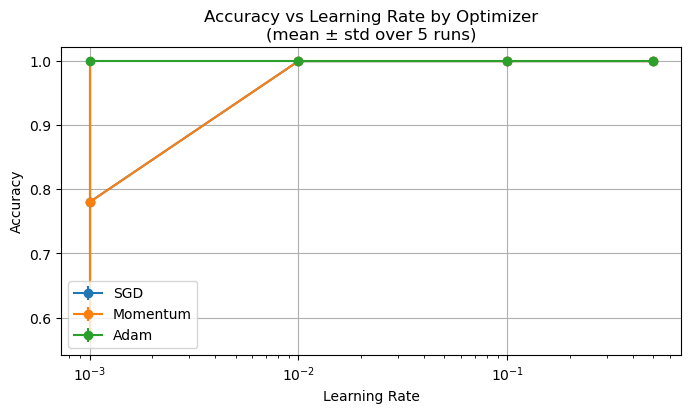

In [25]:
plt.figure(figsize=(8,4))
for opt_name in optimizers:
    subset = agg[agg['Optimizer']==opt_name]
    plt.errorbar(
        subset['Learning Rate'],
        subset['Mean_Acc'],
        yerr=subset['Std_Acc'],
        marker='o',
        label=opt_name
    )
plt.xscale('log'); plt.xlabel('Learning Rate'); plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Learning Rate by Optimizer\n(mean ± std over {runs_per_config} runs)')
plt.legend(); plt.grid(True); plt.show()

#### Loss Plot

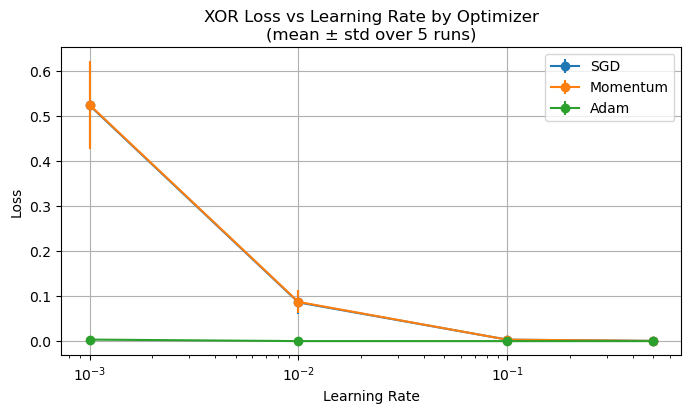

In [26]:
plt.figure(figsize=(8,4))
for opt_name in optimizers:
    subset = agg[agg['Optimizer']==opt_name]
    plt.errorbar(
        subset['Learning Rate'],
        subset['Mean_Loss'],
        yerr=subset['Std_Loss'],
        marker='o',
        label=opt_name
    )
plt.xscale('log'); plt.xlabel('Learning Rate'); plt.ylabel('Loss')
plt.title('XOR Loss vs Learning Rate by Optimizer\n(mean ± std over 5 runs)')
plt.legend(); plt.grid(True); plt.show()

#### Gradient Descent

In [28]:
sgd_loss_curves = {}
sgd_acc_curves  = {}
sgd_loss_std, sgd_acc_std = {}, {}

for lr in learning_rates:
    L = np.zeros((runs_per_config, epochs))
    A = np.zeros((runs_per_config, epochs))
    for run in range(runs_per_config):
        np.random.seed(run)
        opt = SGD_Optimizer(lr)
        mlp = MultiLayerPerceptron(
            layer_sizes=[35, 16, 1], 
            optimizer=opt, 
            activations=['tanh', 'sigmoid'], 
            learning_rate=lr,
            batch_size=10,                  
            shuffle=False,
            loss_kind='cross_entropy',
            verbose=False
        )
        mlp.fit(X, y01, epochs=epochs)
        L[run] = mlp.losses
        A[run] = mlp.accuracies

    sgd_loss_curves[f"lr={lr}"] = L.mean(axis=0)
    sgd_acc_curves [f"lr={lr}"] = A.mean(axis=0)

iters = np.arange(1, epochs+1)


#### Accuracy Plot

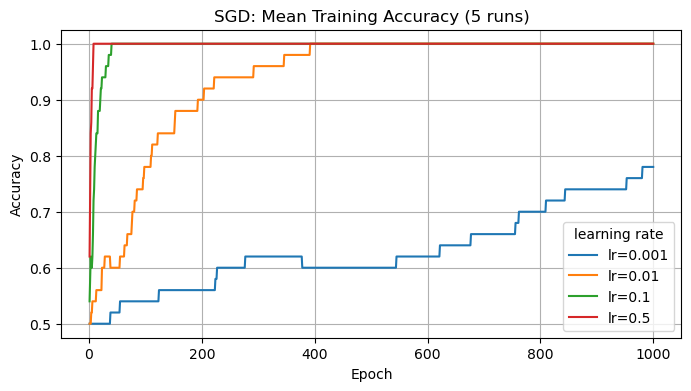

In [29]:
plt.figure(figsize=(8,4))
for label, curve in sgd_acc_curves.items():
    plt.plot(iters, curve, label=label)
plt.title("SGD: Mean Training Accuracy (5 runs)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(title="learning rate")
plt.grid(True)
plt.show()

#### Loss Plot

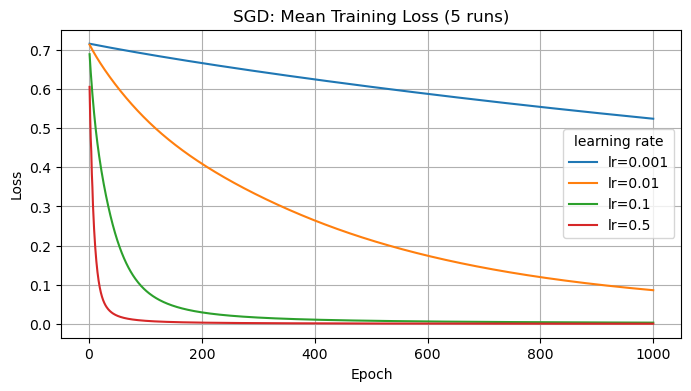

In [30]:
plt.figure(figsize=(8,4))
for label, curve in sgd_loss_curves.items():
    plt.plot(iters, curve, label=label)
plt.title("SGD: Mean Training Loss (5 runs)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(title="learning rate")
plt.grid(True)
plt.show()

####